In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.datasets import load_breast_cancer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity, calculate_kmo

In [2]:
cancer = load_breast_cancer()
df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
df['target'] = cancer.target

print("Dataset shape:", df.shape)
df.head()

Dataset shape: (569, 31)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [3]:
X = df.drop('target', axis=1)
y = df['target']

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [4]:
# --- Suitability Checks ---

# 1. Bartlett's Test
chi_square_value, p_value = calculate_bartlett_sphericity(X_scaled)
print(f"Bartlett's Test Chi-Square: {chi_square_value:.3f}, P-value: {p_value:.3f}")
if p_value < 0.05:
    print("Result: The variables are correlated, and the data is suitable for factor analysis.")
else:
    print("Result: The variables are not correlated enough. Factor analysis may not be appropriate.")

print("\n" + "="*40 + "\n")

# 2. KMO Test
kmo_all, kmo_model = calculate_kmo(X_scaled)
print(f"KMO Test value: {kmo_model:.3f}")
if kmo_model >= 0.6:
    print("Result: The data is adequate for factor analysis.")
elif kmo_model >= 0.5:
    print("Result: The data is marginally acceptable for factor analysis.")
else:
    print("Result: The data is not adequate for factor analysis.")

Bartlett's Test Chi-Square: 39362.121, P-value: 0.000
Result: The variables are correlated, and the data is suitable for factor analysis.


KMO Test value: 0.832
Result: The data is adequate for factor analysis.


C:\Users\basde\AppData\Local\Programs\Python\Python311\Lib\site-packages\factor_analyzer\utils.py:244: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn(


In [5]:
# Fit PCA to get eigenvalues
pca = PCA(n_components=X_scaled.shape[1])
pca.fit(X_scaled)
eigenvalues = pca.explained_variance_

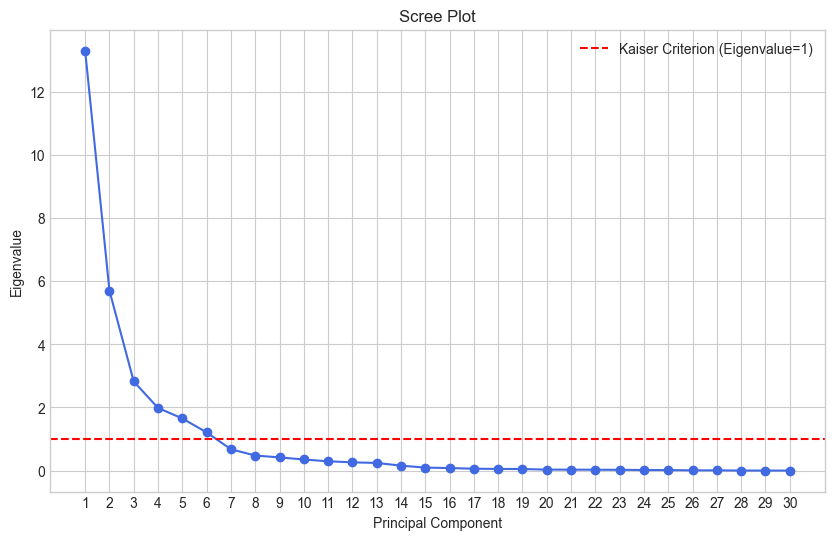

In [6]:
# --- Plot 1: Scree Plot ---
plt.style.use("seaborn-v0_8-whitegrid")
plt.figure(figsize=(10, 6))

plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, 'o-', color='royalblue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='red', linestyle='--', label='Kaiser Criterion (Eigenvalue=1)')
plt.legend()
plt.xticks(range(1, len(eigenvalues) + 1))
plt.show()

# Get the number suggested by Kaiser Criterion
kaiser_components = np.sum(eigenvalues > 1)

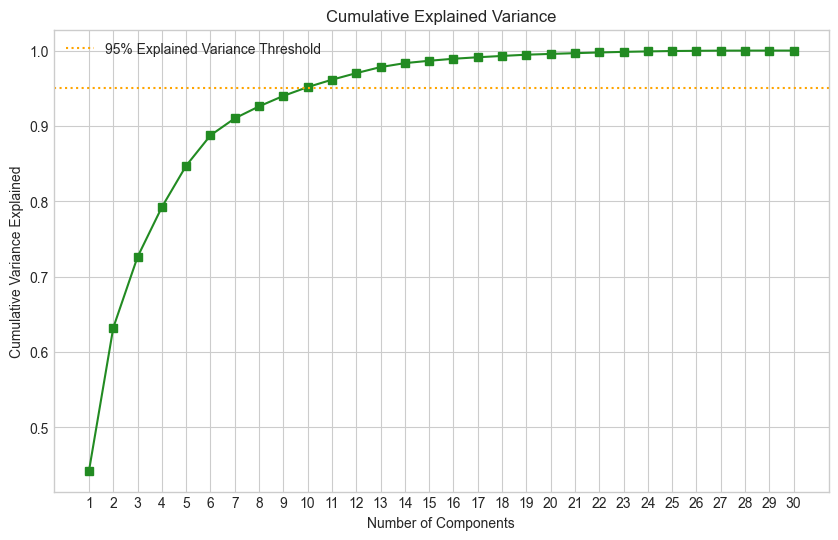

In [25]:
# --- Plot 2: Cumulative Variance (Adaptable with Fallback Test) ---

# Set the threshold 
variance_threshold = 0.95
threshold_met = True # Flag to check if the threshold was met

# --- Calculations ---
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
try:
    n_comp_variance = np.where(cumulative_variance >= variance_threshold)[0][0] + 1
except IndexError:
    
    threshold_met = False
    n_comp_variance = len(cumulative_variance)
    max_variance_val = cumulative_variance[-1]

# --- Plotting (The plot will still render correctly) ---
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 's-', color='forestgreen')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')

plt.axhline(y=variance_threshold, color='orange', linestyle=':', label=f'{int(variance_threshold*100)}% Explained Variance Threshold')

plt.legend()
plt.xticks(range(1, len(eigenvalues) + 1))
plt.grid(True)
plt.show()

Running Parallel Analysis (this may take a moment)...
Done.


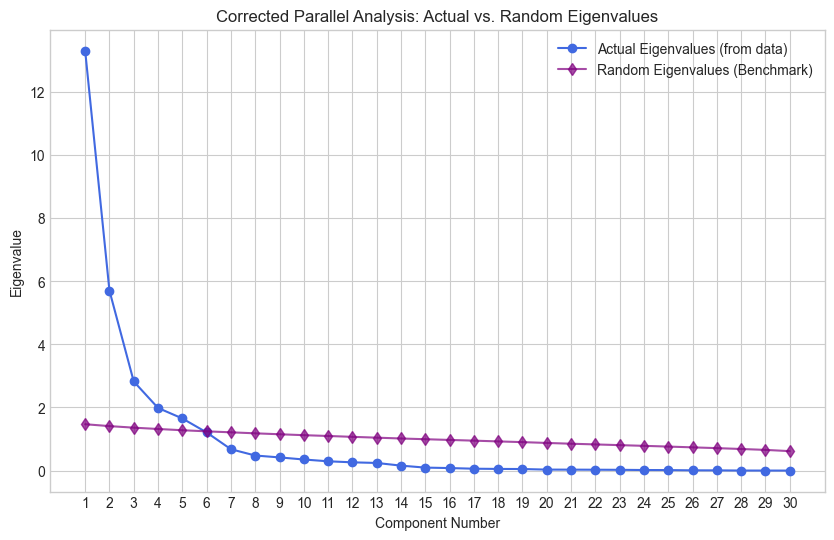

In [12]:
### ## Corrected Plot 3: Parallel Analysis

def parallel_analysis(data, n_iterations=100):
    """
    Performs Horn's Parallel Analysis to determine the number of components to retain.
    """
    n_rows, n_cols = data.shape
    # Store eigenvalues from each random dataset iteration
    random_eigenvalues = np.zeros((n_iterations, n_cols))

    print("Running Parallel Analysis (this may take a moment)...")
    for i in range(n_iterations):
        # 1. Create a random dataset
        random_data = np.random.normal(size=(n_rows, n_cols))
        
        # 2. Run PCA on the random data
        pca_random = PCA(n_components=n_cols)
        pca_random.fit(random_data)
        
        # 3. Store its eigenvalues
        random_eigenvalues[i, :] = pca_random.explained_variance_
    
    # 4. Calculate the average eigenvalues across all iterations
    avg_random_eigenvalues = random_eigenvalues.mean(axis=0)
    print("Done.")
    return avg_random_eigenvalues

# --- Run the corrected analysis ---
# Get eigenvalues from the REAL data (same as before)
pca_actual = PCA(n_components=X_scaled.shape[1])
pca_actual.fit(X_scaled)
actual_eigenvalues = pca_actual.explained_variance_

# Get the benchmark eigenvalues from RANDOM data
random_eigenvalues = parallel_analysis(X_scaled)

# --- Plotting ---
plt.figure(figsize=(10, 6))

# Plot 1: Actual Eigenvalues from the data (Blue)
plt.plot(range(1, len(actual_eigenvalues) + 1), actual_eigenvalues, 'o-', color='royalblue', label='Actual Eigenvalues (from data)')

# Plot 2: Random Eigenvalues benchmark (Purple)
plt.plot(range(1, len(random_eigenvalues) + 1), random_eigenvalues, 'd-', color='purple', alpha=0.7, label='Random Eigenvalues (Benchmark)')

plt.title('Corrected Parallel Analysis: Actual vs. Random Eigenvalues')
plt.xlabel('Component Number')
plt.ylabel('Eigenvalue')
plt.legend()
plt.xticks(range(1, len(actual_eigenvalues) + 1))
plt.grid(True)
plt.show()

# Get the number suggested by the corrected Parallel Analysis
n_factors_pa_corrected = np.sum(actual_eigenvalues > random_eigenvalues_benchmark)

In [14]:
# Create a DataFrame for a clear comparison
comparison_df = pd.DataFrame({
    'Component': range(1, len(eigenvalues) + 1),
    'Actual Eigenvalue': eigenvalues,    'Random Eigenvalue': random_eigenvalues})

# Calculate the difference
comparison_df['Difference'] = comparison_df['Actual Eigenvalue'] - comparison_df['Random Eigenvalue']

# Display the critical part of the table (e.g., the first 10 components)
print("--- Numerical Comparison for Parallel Analysis ---")
print(comparison_df.head(10).round(3))

--- Numerical Comparison for Parallel Analysis ---
   Component  Actual Eigenvalue  Random Eigenvalue  Difference
0          1             13.305              1.469      11.836
1          2              5.701              1.409       4.292
2          3              2.823              1.360       1.463
3          4              1.984              1.318       0.666
4          5              1.652              1.278       0.373
5          6              1.209              1.244      -0.034
6          7              0.676              1.212      -0.536
7          8              0.477              1.180      -0.703
8          9              0.418              1.151      -0.733
9         10              0.351              1.122      -0.770


In [26]:
# --- Final Analysis Summary (Fully Reusable) ---

# --- 1. Generate dynamic interpretation text ---
# (This part for Bartlett's and KMO remains the same)
if p_value < 0.05:
    bartlett_result_text = f"significant (p={p_value:.3f}), indicating correlations are present."
else:
    bartlett_result_text = f"NOT significant (p={p_value:.3f}). Warning: Data may be unsuitable for PCA."

if kmo_model >= 0.6:
    kmo_result_text = f"adequate ({kmo_model:.3f})."
elif kmo_model >= 0.5:
    kmo_result_text = f"marginally acceptable ({kmo_model:.3f})."
else:
    kmo_result_text = f"inadequate ({kmo_model:.3f}). Warning: Data may be unsuitable for PCA."

# --- 2. Generate dynamic recommendation logic ---
suggestions = [n_factors_pa_corrected, kaiser_components, n_comp_variance]
min_recommendation = min(suggestions)
max_recommendation = max(suggestions)


# --- 3. Print the final report ---
print("--- Final Analysis Report ---")

# Section for suitability
print("\n## Data Suitability for PCA")
print(f" * Bartlett's Test was {bartlett_result_text}")
print(f" * The KMO score was {kmo_result_text}")
print("-" * 30)

# Section for component selection methods
print("\n## Component Selection Results")
print(f" * Kaiser Criterion (Eigenvalues > 1) suggests: {kaiser_components} components.")

# This line is now fully dynamic based on whether the threshold was met
if threshold_met:
    print(f" * Cumulative Variance (to explain {int(variance_threshold*100)}%) requires: {n_comp_variance} components.")
else:
    print(f" * Cumulative Variance: Your {int(variance_threshold*100)}% threshold was not met. The max possible is {max_variance_val*100:.2f}% with all {n_comp_variance} components.")

print(f" * Parallel Analysis (the most reliable method) suggests: {n_factors_pa_corrected} components.")
print("-" * 30)

# Section for the final recommendation
print("\n## Final Recommendation")
print(f"The evidence points towards choosing between {min_recommendation} and {max_recommendation} components.")
print(f"A conservative, statistically-backed estimate from Parallel Analysis suggests {n_factors_pa_corrected} components, which is excellent for avoiding noise.")

# This line is also fully dynamic
if threshold_met:
    print(f"A more liberal approach focused on retaining information ({int(variance_threshold*100)}% variance) requires {n_comp_variance} components.")
else:
    print(f"The most liberal approach (all components) only captures {max_variance_val*100:.2f}% of the variance, requiring {n_comp_variance} components.")

print("\n**Next Step**: The best practice is to treat n_components as a hyperparameter. Test the range from "
      f"{min_recommendation} to {max_recommendation} in a cross-validation loop with your machine learning model to find the empirical optimum.")

--- Final Analysis Report ---

## Data Suitability for PCA
 * Bartlett's Test was significant (p=0.000), indicating correlations are present.
 * The KMO score was adequate (0.832).
------------------------------

## Component Selection Results
 * Kaiser Criterion (Eigenvalues > 1) suggests: 6 components.
 * Cumulative Variance (to explain 95%) requires: 10 components.
 * Parallel Analysis (the most reliable method) suggests: 5 components.
------------------------------

## Final Recommendation
The evidence points towards choosing between 5 and 10 components.
A conservative, statistically-backed estimate from Parallel Analysis suggests 5 components, which is excellent for avoiding noise.
A more liberal approach focused on retaining information (95% variance) requires 10 components.

**Next Step**: The best practice is to treat n_components as a hyperparameter. Test the range from 5 to 10 in a cross-validation loop with your machine learning model to find the empirical optimum.
